# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import pandas_datareader as pdr
from __future__ import division
import random
import math
import time
from pyswarm import pso
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit

# Load Data

In [3]:
# com = 'Apple'
# share = 'AAPL'
com="FMC"
share="FMC"
start = '2016-01-04'
end = '2020-10-12'

### SAVE DATA TO CSV

In [4]:
total_extensions=[
                  "ADBE",
                  "XOM",
                  "AMZN",
                  "GOOGL",
                  "NFLX",
                  "MSFT",
                  "PG",
                  "JNJ",
                  "PYPL",
                  "GS",
                  "NVDA",
                  "VZ",
                  ]
for ext in total_extensions:
  data=pdr.get_data_yahoo(ext, start=start, end=end)
  data.to_csv(f"./data/{ext}.csv")

In [223]:
data = pdr.get_data_yahoo(share, start=start, end=end)

data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-01-04,33.052906,32.081528,32.792713,32.940155,2017058.0,30.232710
2016-01-05,33.434521,32.385082,32.992195,32.593235,1630342.0,29.914309
2016-01-06,32.081528,31.032089,31.994797,31.240244,1671965.0,28.672523
2016-01-07,31.422377,30.268864,30.789246,30.988726,2487598.0,28.441677
2016-01-08,31.682568,30.867304,31.170858,30.936687,1785536.0,28.393917
...,...,...,...,...,...,...
2020-10-06,106.980003,103.639999,105.860001,103.820000,768600.0,101.964607
2020-10-07,106.860001,105.330002,105.449997,106.279999,554500.0,104.380646
2020-10-08,107.629997,105.919998,106.949997,106.059998,457600.0,104.164574


# Features

In [224]:
# MF
def MF(high, low, close, volume):
    mf = (high + low + close) / 3 * volume
    return mf 

In [225]:
# EMA
def EMA(data):
    data_float = data.astype(float)
    return data_float.ewm(span = 20).mean()

In [226]:
# MFI
def MFI(data):
    returns = data - data.shift(1)
    returns.dropna()
    up, down = returns.copy(), returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    
    try:
      mfi = 100 - 100 / (1 + upm / downm)
      return mfi
    except ZeroDivisionError:
      return 0

In [227]:
# RSI
def RSI(data):
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(), returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    try:
      rsi = 100 - 100 / (1 + upm / downm)
      return rsi
    except ZeroDivisionError:
      return 0 

In [228]:
# MACD
def MACD(ema):
    high = 0.075 * ema
    low = 0.15 * ema
    macd = high - low
    return macd

In [229]:
def oscillator(data):
    curr = data[-1]
    data = list(data)
    high = max(data)
    low = min(data)
    so = (curr - low) / (high - low) * 100 
    return so

In [230]:
data['MF'] = MF(data['High'], data['Low'], data['Close'], data['Volume'])
data['EMA'] = EMA(data.iloc[:, [3]])
data['RSI'] = data['Close'].rolling(7).apply(RSI)
data['MFI'] = data['MF'].rolling(7).apply(MFI)
data['SO'] = data['Close'].rolling(7).apply(oscillator)
data['MACD'] = MACD(data.iloc[:,[7]])
data['MACD_Signal'] = MACD(data.iloc[:, [11]])

data.drop(['Adj Close', 'MF', 'MACD_Signal'], axis=1, inplace=True)

data

,High,Low,Open,Close,Volume,EMA,RSI,MFI,SO,MACD
Date,,,,,,,,,,
2016-01-04,33.052906,32.081528,32.792713,32.940155,2017058.0,32.940155,NaN,NaN,NaN,-2.470512
2016-01-05,33.434521,32.385082,32.992195,32.593235,1630342.0,32.758022,NaN,NaN,NaN,-2.456852
2016-01-06,32.081528,31.032089,31.994797,31.240244,1671965.0,32.200703,NaN,NaN,NaN,-2.415053
2016-01-07,31.422377,30.268864,30.789246,30.988726,2487598.0,31.850824,NaN,NaN,NaN,-2.388812
2016-01-08,31.682568,30.867304,31.170858,30.936687,1785536.0,31.629702,NaN,NaN,NaN,-2.372228
...,...,...,...,...,...,...,...,...,...,...
2020-10-06,106.980003,103.639999,105.860001,103.820000,768600.0,106.279283,34.335861,56.847789,20.127725,-7.970946
2020-10-07,106.860001,105.330002,105.449997,106.279999,554500.0,106.279351,55.143162,57.411563,100.000000,-7.970951
2020-10-08,107.629997,105.919998,106.949997,106.059998,457600.0,106.258461,50.828695,44.786887,92.880211,-7.969385


# Preprocessing

In [231]:
xdata = data.dropna()
ydata = pd.DataFrame(xdata['Close'].shift(-7))
ydata.dropna(inplace=True)
xdata  = xdata[:-7]
xcols = xdata.columns
xdates = xdata.index

ycols = ydata.columns
ydates = ydata.index

print(xdata.shape)
print(ydata.shape)

(1190, 10)
(1190, 1)


In [232]:
from sklearn.preprocessing import StandardScaler
xscaler = StandardScaler()
yscaler = StandardScaler()
xdata = pd.DataFrame(xscaler.fit_transform(xdata))
ydata = pd.DataFrame(yscaler.fit_transform(ydata))

xdata.columns = xcols
xdata.index = xdates

ydata.columns = ycols
ydata.index = ydates

In [233]:
x_trains, y_trains = xdata[:900], ydata[:900]
y_trains = pd.DataFrame(y_trains)
x_tests, y_tests = xdata[900:], ydata[900:]
y_tests = pd.DataFrame(y_tests)
y_tests.dropna(inplace=True)

print(x_tests.shape)
print(y_tests.shape)
print(x_trains.shape)
print(y_trains.shape)

(290, 10)
(290, 1)
(900, 10)
(900, 1)


# LSSVR

In [234]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from scipy.sparse import linalg


class LSSVR1(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=None):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.gamma = gamma
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        t = pd.DataFrame(t)
        t[1:n] = self.supportVectorLabels.values
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias

    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
        return k

Dragonfly optimizer

In [235]:
 
import math
import numpy as np
import random
class dragonfly:
  def Levy(self,dim):
    beta=1.5
    sigma=((math.gamma(1+beta)*math.sin(math.pi*beta/2))/(math.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    r1=random.random()
    r2=random.random()
    return 0.01*((r1*sigma)/(r2**(1/beta)))

  def dist_of_all_dim(self,dim,arr1,arr2):
    ans=np.zeros((dim))
    for i in range(0,dim):
      ans[i]=math.fabs(arr1[i]-arr2[i])
    return ans
  
  def is_neighbour(self,dim,arr1,arr2,r):
    same=0
    #checks over all the dimensions and sees if it is in range and also sees if all
    #the locations are exactly same. If so, then returns false otherwise true.
    for i in range(0,dim):
      diff_val=math.fabs(arr1[i]-arr2[i])
      # print(f"type of diff_val: {type(diff_val)}")
      # print(f"type of r: {type(r)}")
      if diff_val>r[i]:
        return False
      if diff_val==0:
        same+=1
    if(same==dim):
      return False
    else:
      return True

  def initialize(self,n,dim,ub,lb):
    ans=np.zeros((n,dim),dtype="float")
    #randomly generating all the elements
    for i in range(0,n):
      for j in range(0,dim):
        #point to note: rand(a,b) means [a,b] both ranges inclusive
        ans[i][j]=(random.random())*(ub[j]-lb[j])+lb[j]
    return ans

  def find_neighbours(self,pop,agent,r):
    neighbours = []
    for i in range(np.shape(pop)[0]):
        if self.is_neighbour(np.shape(pop)[1],agent,pop[i],r):
            neighbours.append(i)
    neighbour_list = np.zeros(len(neighbours),dtype="int")
    for i in range(len(neighbours)):
        neighbour_list[i] = neighbours[i]
    return neighbour_list
    #fixed bugs but still not tested as a whole
  def altruism(self,obj,dragonflies,rang,food,f_factor,enemy,e_factor,lb,ub):

      agents = dragonflies.copy()
      rows,cols = np.shape(agents)
      
      #find altruist i.e., the worst dragonfly
      altruist = 0
      altruist_fit = obj(agents[altruist])
      for i in range(1,rows):
        if obj(agents[i]) > altruist_fit:
          altruist = i
          alturist_fit = obj(agents[i])

      #find all neighbours of altruist
      """neighbours = []
      for i in range(rows):
        if i == altruist:
          continue
        if self.is_neighbour(cols,agents[altruist],agents[i],rang):
          neighbours.append(i)"""
      neighbours = self.find_neighbours(agents,agents[altruist],rang)

      if len(neighbours) == 0:
        return dragonflies
      
      #find beneficiary
      beneficiary = np.random.randint(0,len(neighbours))

      fitness_alt = altruist_fit
      # fitness_ben = obj(beneficiary)
      fitness_ben=obj(agents[beneficiary])

      #find Hamilton equation's factor
      distance = np.zeros(cols)
      for i in range(cols):
        distance[i] = abs(agents[altruist][i]-agents[beneficiary][i])

      #closer the beneficiary, lesser the scaling required
      #second part will always be less than 1
      r = 1 - np.sum(distance)/np.sum(rang)

      #generate a random number for the food offset
      dist1 = self.dist_of_all_dim(cols,food,agents[altruist])
      dist2 = self.dist_of_all_dim(cols,food,agents[beneficiary])
      dist3 = self.dist_of_all_dim(cols,enemy,agents[altruist])
      dist4 = self.dist_of_all_dim(cols,enemy,agents[beneficiary])

      for i in range(cols):

        offset = np.random.uniform(low=0,high=min(abs(dist1[i]),abs(dist2[i]),abs(rang[i])))

        #need not change delta as it will anyways change on next iteration
        agents[altruist][i] += (f_factor*offset)
        agents[beneficiary][i] -= (f_factor*offset)

        offset = np.random.uniform(low=0,high=min(abs(dist3[i]),abs(dist4[i]),abs(rang[i])))

        #need not change delta as it will anyways change on next iteration
        agents[altruist][i] -= (e_factor*offset)
        agents[beneficiary][i] += (e_factor*offset)

      #perform clipping
      for i in range(cols):
        agents[altruist][i] = min(agents[altruist][i],ub[i])
        agents[altruist][i] = max(agents[altruist][i],lb[i])
        agents[beneficiary][i] = min(agents[beneficiary][i],ub[i])
        agents[beneficiary][i] = max(agents[beneficiary][i],lb[i])

      #check if altruism is successful
      # benefit = obj(beneficiary)
      benefit=obj(agents[beneficiary])
      # cost = obj(altruist)
      cost=obj(agents[altruist])
      if benefit-fitness_ben <= 0 and cost-fitness_alt >= 0:
        benefit = fitness_ben - benefit
        cost = cost - fitness_alt
      else:
        return dragonflies
      if r*benefit > cost:
        return agents
      else:
        return dragonflies

  def optimize(self,obj,dim,bound,n,max_it):
    #getting the dimensions
    # dim=np.size(bound)[2]
    ub=np.zeros((dim),dtype="float")
    lb=ub.copy()
    
    #setting the values of the range
    for i in range(0,dim):
      lb[i]=bound[i][0]
      ub[i]=bound[i][1]
    
    #setting the initial r. In paper code, this magic_r_val was 10
    magic_r_val=10
    r=(ub-lb)/magic_r_val
    delta_max=(ub-lb)/magic_r_val
    
    #should I set the best and worst fitness as the enemy and food respectively at the begining???

    #setting the enemy and food fitness
    food_fitness=np.inf
    enemy_fitness=-np.inf
    #setting the initial food and enemy position
    #maybe change it to better suit the needs
    food_pos=np.zeros((dim),dtype="float")
    enemy_pos=np.zeros((dim),dtype="float")
    
    #initializing the dragonflies X aka positions
    x=self.initialize(n,dim,ub,lb)
    #probably change this
    delta_x=self.initialize(n,dim,ub,lb)

    #main loop
    for iter in range(1,max_it+1):

      #a lot of magic numbers here
      r=(ub-lb)/4+((ub-lb)*(iter/max_it)*2)

      w=0.9-iter*((0.9-0.4)/max_it)
        
      my_c=0.1-iter*((0.1-0)/(max_it/2))
      if(my_c<0):
        my_c=0
      s=2*(random.random())*my_c
      a=2*(random.random())*my_c
      c=2*(random.random())*my_c
      f=2*(random.random());     
      e=my_c
      fitness_prev=np.zeros((n))
      #calculating the fitness values of the dragonflies
      for i in range(0,n):
        cur_fitness=obj(x[i,:])
        fitness_prev[i]=cur_fitness
        print(f"cur_fitness for {i} with {x[i,:]}: {cur_fitness}")
        #possible confusion about bound checking here
        #i deemed that not useful
        if cur_fitness>enemy_fitness:
          enemy_fitness=cur_fitness
          enemy_pos=x[i,:].copy()
        if cur_fitness<food_fitness:
          print(f"for updation: {cur_fitness}, {food_fitness}")
          food_fitness=cur_fitness
          food_pos=x[i,:].copy()
      print(f"in loop {iter}, fit: {food_fitness}, loc: {food_pos}")
      #updating the dragonflies one by one
      for i in range(0,n):
        # #calculating the neighbours
        # total_neighbour=0
        # neighbour_index=np.zeros((n),dtype="int")
        # for j in range(0,n):
        #   if self.is_neighbour(dim,x[i,:],x[j,:],r):
        #     neighbour_index[total_neighbour]=j
        #     total_neighbour+=1
        neighbour_index = self.find_neighbours(x,x[i],r)
        total_neighbour = len(neighbour_index)
        #calculating the s,c,a,f,e parameters
        #possible confusion:
        #the default case should be done when number of neighbours ==0 ( but it is given as 1 in the paper code)

        #s
        #huge problem in the S calculation paper says x[k]-x but code from other source says x-x[k]
        Separation=np.zeros((dim),dtype="float")
        for k in range(0,total_neighbour):
          # print(f"type of nei_index: {np.shape(neighbour_index)}")
          Separation+=x[neighbour_index[k],:]-x[i,:]
        #a
        Alignment=np.zeros((dim),dtype="float")
        if total_neighbour>0:
          for k in range(0,total_neighbour):
            Alignment+=delta_x[neighbour_index[k],:]
          Alignment/=total_neighbour
        else:
          Alignment=delta_x[i,:].copy()
        #c
        Cohesion=np.zeros((dim),dtype="float")
        if total_neighbour>0:
          for k in range(0,total_neighbour):
            Cohesion+=x[neighbour_index[k],:]
          Cohesion/=total_neighbour
        else:
          Cohesion=x[i,:].copy()
        Cohesion-=x[i,:]
        #f
        dist_to_food=self.dist_of_all_dim(dim,food_pos.copy(),x[i,:])
        Food_attr=np.zeros((dim),dtype="float")
        #checking if food is in reach
        if np.shape(np.where(dist_to_food<=r))[1]==dim: #careful with the expr
          Food_attr=food_pos.copy()-x[i,:]
        #e
        dist_to_enemy=self.dist_of_all_dim(dim,enemy_pos.copy(),x[i,:])
        Enemy_attr=np.zeros((dim),dtype="float")
        #checking if enemy is in reach
        if np.shape(np.where(dist_to_enemy<=r))[1]==dim: #careful with the expr
          Enemy_attr=enemy_pos.copy()+x[i,:]
        
        #clipping but it looks very fishy. because >ub becomes lb and <lb becomes ub
        for j in range(0,dim):
          if x[i,j]>ub[j]:
            x[i,j]=lb[j] #check
            delta_x[i,j]=random.random()
          if x[i,j]<lb[j]:
            x[i,j]=ub[j] #check
            delta_x[i,j]=random.random()
        
        #checking to see if any food_dimension in out of reach
        if np.shape(np.where(Food_attr>r))[1]>0: #careful with the expr
          if total_neighbour>0:
            for j in range(0,dim):
              delta_x[i,j]=w*delta_x[i,j]+(random.random())*Alignment[j]+(random.random())*Cohesion[j]+(random.random())*Separation[j]
              if delta_x[i,j]>delta_max[j]:
                delta_x[i,j]=delta_max[j]
              if delta_x[i,j]<-delta_max[j]:
                delta_x[i,j]=-delta_max[j]
              x[i,j]+=delta_x[i,j]
          else:
            x[i,:]+=self.Levy(dim)*x[i,:]#need to implement levy
            delta_x[i,:]=np.zeros((dim),dtype="float")
        else:
          for j in range(0,dim):
            delta_x[i,j]=(a*Alignment[j]+c*Cohesion[j]+s*Separation[j]+f*Food_attr[j]+e*Enemy_attr[j])+w*delta_x[i,j]
            if delta_x[i,j]>delta_max[j]:
              delta_x[i,j]=delta_max[j]
            if delta_x[i,j]<-delta_max[j]:
              delta_x[i,j]=-delta_max[j]
            x[i,j]+=delta_x[i,j]

        
        #temporary clipping
        for j in range(0,dim):
          if x[i,j]>ub[j]:
            x[i,j]=ub[j]
          if x[i,j]<lb[j]:
            x[i,j]=lb[j]
        # print(f"cur x val for {i} : {x[i,:]}")


        #there were these 3 lines of matlab code that I could not decipher:
        #didn't understand what they do

        # Flag4ub=X(:,i)>ub';
        # Flag4lb=X(:,i)<lb';
        # X(:,i)=(X(:,i).*(~(Flag4ub+Flag4lb)))+ub'.*Flag4ub+lb'.*Flag4lb;
      
      #altruism call
      #opportunistic altruism 
      temp_pop=self.altruism(obj,x,r,food_pos,f,enemy_pos,e,lb,ub)
      fitness_new=np.zeros((n))
      for t in range(0,n):
        fitness_new[t]=obj(temp_pop[t,:])
        # fitness_prev[t]=obj(x[t,:])
      if(min(fitness_new)<min(fitness_prev)):
        x=temp_pop
      #
      #x = self.altruism(obj,x,r,food_pos,f,enemy_pos,e,lb,ub)
    return food_pos,food_fitness #returning loc and fit      

# Main

In [236]:
fold_count=10 

def load_csvdata():
    global X
    global Y
    
    X = xdata
    Y = ydata

def svrPso(params,problem_size = 2):
    kf = TimeSeriesSplit(n_splits=fold_count)
    for train, test in kf.split(X):
        Total = 0
         
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
        nn = LSSVR1(kernel = 'rbf',C=params[0], gamma = params[1])
        nn.fit(X_train,y_train)
        result = nn.predict(X_test);
        thisError = calsError(y_test, result)
        Total = Total + thisError    
    ErrorCV = Total/fold_count; 
    # print('Optimizing the Parameters ..... C = {c}, gamma={e}, MSE={m}'.format(c=params[0], e=params[1], m=ErrorCV))
    return ErrorCV

def calsError(y_test, result):
    y_pred = pd.DataFrame(result)
    y_pred.index = y_test.index
    data = pd.concat([y_test,y_pred],axis=1)
    data['Error'] = (data['Close'] - data[0])**2
    err = np.sqrt(np.sum(data['Error']))
    
    return err
    
def main_run(algo):
    
        load_csvdata()
        if  algo == dragonfly:
            #For SSA
            # bounds=[(0.01,150),(0.002,500)] #initial from prev paper 
            # bounds= [(0.01,100),(0.0001,1)] #my proposed 
            # bounds=[(0.01,1000),(0.0001,500)] #hybridized
            bounds= [(0.0001,10000),(0.00001,1000)] #hybridized again
            # bounds= [(0.0001,10000),(1e-6,1000)]
            # opt = algo(bounds)
            opt=dragonfly()
            num_dragfly=20
            num_iter=30
            loc,fit = opt.optimize(svrPso,2,bounds, num_dragfly,num_iter)

        print(" ")
        print("************ Objective Function optimized *****************")
        print ('Best Location - ',loc)
        print ('Best Fitness - ',fit)
        print(" ")
        print(" ")

        return loc,fit

# Results

In [237]:
algo = dragonfly
print("************  Initializing Optimization *****************")
# tic = time.time()
loc,fit = main_run(algo)

# print(f"loc: {loc} and fit: {fit}")
# toc = time.time()
# print('Time Taken is {time} secs'.format(time = (toc - tic)))
# print (f'Optimizer used is - {algo.__name__} with 30 epochs of 20 particles for {com} from Date - {start}.')

************  Initializing Optimization *****************
cur_fitness for 0 with [9502.04102605  967.17291065]: 1.8283333164228117
for updation: 1.8283333164228117, inf
cur_fitness for 1 with [6225.77053179  340.96680683]: 1.8283482929137083
cur_fitness for 2 with [4967.11353662  231.96222924]: 1.828410124153479
cur_fitness for 3 with [7228.14293085  917.70044007]: 1.8283333320820632
cur_fitness for 4 with [3660.48123894  417.56426269]: 1.8283383142114609
cur_fitness for 5 with [5613.04199659  709.14851471]: 1.8283335378241123
cur_fitness for 6 with [4910.61931577  943.78008513]: 1.8283333230604384
cur_fitness for 7 with [663.85077029 482.5528107 ]: 1.8283354808857126
cur_fitness for 8 with [9157.5588455   199.30608869]: 1.8284553263924253
cur_fitness for 9 with [7144.78119352  924.06385937]: 1.8283333297061328
cur_fitness for 10 with [3849.51805653  442.23394872]: 1.8283369138189625
cur_fitness for 11 with [4511.9369673   398.16893268]: 1.8283398474799992
cur_fitness for 12 with [6403

In [238]:
#C, gamma = 138.85609288790423, 0.002
# print(loc)
# print(fit)
print("{:10.8} {:10.6} {:10.10} {:10.10} {:10.10}".format(com,share,loc[0],loc[1],fit))

FMC        FMC           10000.0      1e-05 0.2079037801


In [239]:
model = LSSVR1(kernel='rbf',C=loc[0], gamma=loc[1])
# model= LSSVR1(kernel="rbf",C=50,gamma=0.0005)
model.fit(x_trains, y_trains)
res = model.predict(x_tests)
res = pd.DataFrame(res)
res.index = y_tests.index

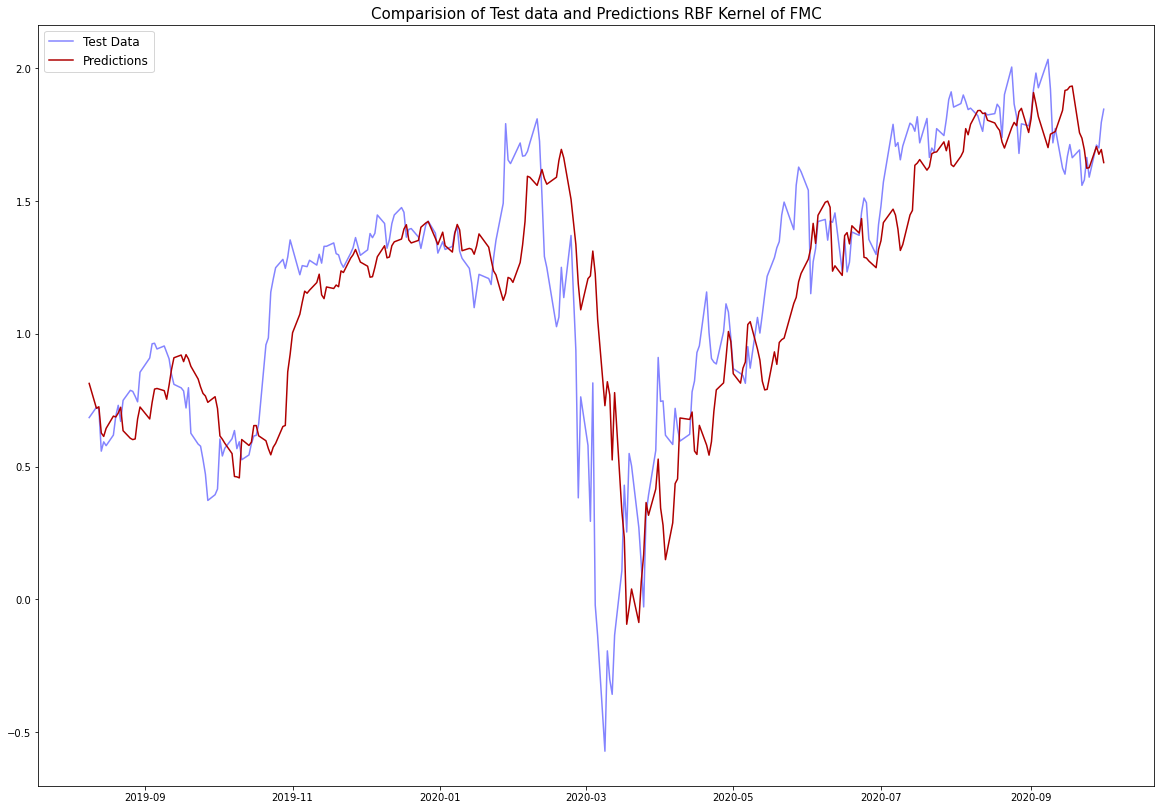

In [240]:
plt.figure(figsize = (20,14))
plt.plot(y_tests,color="#0A0AFF",alpha=0.5,label="Test Data")
plt.plot(res,color="#AF0000",label="Predictions")
plt.title(f"Comparision of Test data and Predictions RBF Kernel of {com}",fontsize=15)
plt.legend(fontsize="large")